# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

import time

In [2]:
#ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_FZ_filtered_rainfall.nc')
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

In [3]:
#slice to one month
ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

## Calculate distance matrix

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## SO filter (fixed evaluation period only)

In [6]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.35 # 0.15 original (gives very few SO-flags)
beta = 0.2
n_stat = 5
max_distance = 10e3 # Boolean 2D data array, defining neihbours within max_distance for all stations
dbc = 1

In [7]:
# initalize SO-flag
ds_pws["so_flag"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [24]:
# initalize nr of rainy timesteps in last mint period
ds_pws["rainy_timesteps"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [26]:
def rainy_timesteps(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()

    rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps}))

    # compare if rainy timesteps is above threshold mrain
    # if true --> apply SO-filter as it is now (fixed window)
    # if false ---> go back in time?
    return ds

In [29]:
test = rainy_timesteps(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
#ds_pws.rainy_timesteps[i, :] = test
test

<xarray.Dataset>
Dimensions:          (id: 22, time: 8928)
Coordinates:
  * id               (id) object 'ams2' 'ams3' 'ams4' ... 'ams24' 'ams26'
  * time             (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
Data variables:
    rainy_timesteps  (id, time) float64 1.0 2.0 3.0 4.0 ... 278.0 279.0 279.0

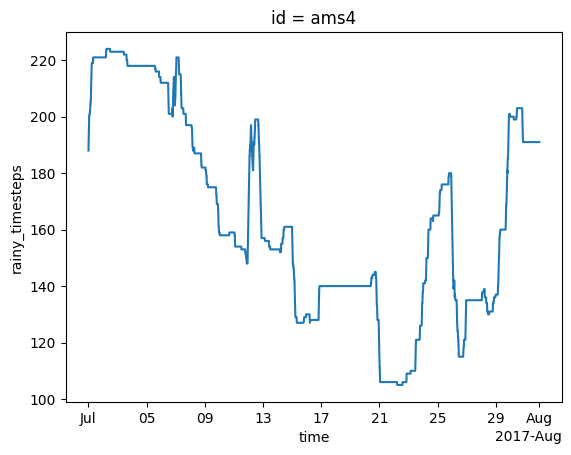

In [31]:
test.rainy_timesteps.isel(id = 2).plot()

In [27]:
def SO_filter(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    
    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    
    mean_corr = ds.mean(dim = "id", skipna = True)
    return xr.where(mean_corr.corr < gamma, 1, 0) 


In [29]:
%%time

for i in range(len(ds_pws.id)):

    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # one bias correction factor per station, iteratively updated PER TIME STEP ??
    BCF_prev = dbc

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # if there are less than mmatch overlapping rainy timesteps in the last mint period, filter cannot be applied
    # number of rainy time steps in rolling window of lenght mint
    # matches = rainy_timesteps(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
    # xr.where(matches < mmatch, 1, 0)
    
    # if there are no observations in the time series, filter cannot be applied
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        # print(pws_id, " has no data")
        ds_pws.so_flag[i, :] = -1
        
    # if there are not enough stations nearby, filter cannot be applied
    elif (len(neighbor_ids) < n_stat):
        # print(pws_id, "has less than", n_stat, "neighbors")
        ds_pws.so_flag[i, :] = -1
        
    else: 
        # print("calculating SO-flag for", pws_id)
        ds_corr = SO_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
        ds_pws.so_flag[i, :] = ds_corr.data
        

CPU times: total: 93.8 ms
Wall time: 99.3 ms


C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Code below: very cumbersome way to identify if fixed or variable evaluation period.

## Bias (next step to fix - how to calculate ROLLING bias?) 

In [7]:
# initialize 
ds_pws["bias"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [21]:
#bias for the whole time series with nbrs, one station
i = 0

pws_id = ds_station.id.values
ds_station = ds_pws.isel(id=i) 

neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]
ds_neighbors = ds_pws.sel(id=neighbor_ids)

delta_r = ds_station.rainfall - ds_neighbors.rainfall
bias = np.nanmean(delta_r) / np.nanmean(ds_neighbors.rainfall)

# how to make rolling bias? 

In [16]:
def bias(station_rainfall, reference_rainfall):
    delta_r = station_rainfall - reference_rainfall
    return np.nanmean(delta_r) / np.nanmean(reference_rainfall)

In [ ]:
def bias_test(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    bias = np.nanmean(delta_r) / np.nanmean(reference_rainfall)
    # roll_bias = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

In [17]:
ds_bias = bias(ds_station.rainfall, ds_neighbors.rainfall, window_length)
# bias_list.append(ds_corr.corr.median(dim='id'))

# Update bias or keep bias 

In [16]:
# ds_pws['median_corr'] = (('id', 'time'), corr_list)

In [17]:
# add flags to dataset
# ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [18]:
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

In [19]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)